# LSTM Network for Regression

#### Case study: International Airline Passengers prediction problem
  Given the number of passengers (in units of thousands) this month, what is the number of passengers next month?
  Note: number of international airline passengers in units of 1,000
  
  Source: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

#### Import packages

In [67]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#### Fix random seed for reproducibility

In [48]:
numpy.random.seed(7)

#### Load the dataset

In [49]:
dataframe = pandas.read_csv('AirPassengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')
print(dataset)

[[112.]
 [118.]
 [132.]
 [129.]
 [121.]
 [135.]
 [148.]
 [148.]
 [136.]
 [119.]
 [104.]
 [118.]
 [115.]
 [126.]
 [141.]
 [135.]
 [125.]
 [149.]
 [170.]
 [170.]
 [158.]
 [133.]
 [114.]
 [140.]
 [145.]
 [150.]
 [178.]
 [163.]
 [172.]
 [178.]
 [199.]
 [199.]
 [184.]
 [162.]
 [146.]
 [166.]
 [171.]
 [180.]
 [193.]
 [181.]
 [183.]
 [218.]
 [230.]
 [242.]
 [209.]
 [191.]
 [172.]
 [194.]
 [196.]
 [196.]
 [236.]
 [235.]
 [229.]
 [243.]
 [264.]
 [272.]
 [237.]
 [211.]
 [180.]
 [201.]
 [204.]
 [188.]
 [235.]
 [227.]
 [234.]
 [264.]
 [302.]
 [293.]
 [259.]
 [229.]
 [203.]
 [229.]
 [242.]
 [233.]
 [267.]
 [269.]
 [270.]
 [315.]
 [364.]
 [347.]
 [312.]
 [274.]
 [237.]
 [278.]
 [284.]
 [277.]
 [317.]
 [313.]
 [318.]
 [374.]
 [413.]
 [405.]
 [355.]
 [306.]
 [271.]
 [306.]
 [315.]
 [301.]
 [356.]
 [348.]
 [355.]
 [422.]
 [465.]
 [467.]
 [404.]
 [347.]
 [305.]
 [336.]
 [340.]
 [318.]
 [362.]
 [348.]
 [363.]
 [435.]
 [491.]
 [505.]
 [404.]
 [359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]


#### Normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library

In [50]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
print(dataset)

[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]
 [0.08494207]
 [0.08494207]
 [0.06177607]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123553]
 [0.04247104]
 [0.07142857]
 [0.05984557]
 [0.04054055]
 [0.08687258]
 [0.12741312]
 [0.12741312]
 [0.10424709]
 [0.05598456]
 [0.01930502]
 [0.06949806]
 [0.07915059]
 [0.08880308]
 [0.14285713]
 [0.11389962]
 [0.13127413]
 [0.14285713]
 [0.18339768]
 [0.18339768]
 [0.15444016]
 [0.11196911]
 [0.08108109]
 [0.1196911 ]
 [0.12934363]
 [0.14671814]
 [0.17181468]
 [0.14864865]
 [0.15250966]
 [0.22007722]
 [0.24324325]
 [0.26640925]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374519]
 [0.17760617]
 [0.17760617]
 [0.25482625]
 [0.25289574]
 [0.24131274]
 [0.26833975]
 [0.3088803 ]
 [0.32432434]
 [0.25675675]
 [0.20656371]
 [0.14671814]
 [0.18725869]
 [0.19305018]
 [0.16216215]
 [0.25289574]
 [0.23745173]
 [0.25096524]
 [0.3088803 ]
 [0.38223937]
 [0.36486486]
 [0.2992278 ]
 [0.24131274]
 [0.1911197 ]
 [0.24

#### Split the ordered dataset into train and test datasets

In [51]:
train_size = int(len(dataset) * 0.67) #67% of data as train data
test_size = len(dataset) - train_size #33% of data as test data
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


#### Convert an array of values into a dataset matrix
convert single column of data into a two-column dataset: the first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

In [57]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

#### Reshape into X=t and Y=t+1

In [58]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

#### Reshape input to be [samples, time steps, features]

In [59]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### Create and fit the LSTM network
A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
Available optimizers for Sequential compile:
   1. SGD - Gradient descent (with momentum) optimizer
   2. RMSprop - RMSprop algorithm which uses plain momentum, not Nesterov momentum
   3. Adam - Adam optimization which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments
   4. Adadelta - Adadelta optimization which is a stochastic gradient descent method that is based on adaptive learning rate per dimension 
   5. Adagrad - optimizer with parameter-specific learning rates, which are adapted relative to how frequently a parameter gets updated during training
   6. Adamax - t is a variant of Adam based on the infinity norm
   7. Nadam - Adam with Nesterov momentum
   8. Ftrl

Available losses for Sequential compile:
  1. Hinge Losses in Keras
    - Hinge
    - Categorical Hinge
    - Squared Hinge
  2. Regression Loss functions in Keras
    - Mean Square Error
    - Mean Absolute Error
    - Cosine Similarity
    - Huber Loss
    - Mean Absolute Percentage Error
    - Mean Squared Logarithmic Error
    - Log Cosh
  3. Binary and Multiclass Loss in Keras
    - Binary Cross Entropy.
    - Categorical Cross Entropy.
    - Poisson Loss.
    - Sparse Categorical Cross Entropy.
    - KLDivergence
  
  
  
  
  Ref: https://keras.io/api/optimizers/
  
  https://keras.io/api/losses/

In [60]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) #visible layer with 1 input, a hidden layer with 4 LSTM blocks or neuron
model.add(Dense(1)) #output layer that makes a single value prediction
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
94/94 - 2s - loss: 0.0442
Epoch 2/100
94/94 - 0s - loss: 0.0207
Epoch 3/100
94/94 - 0s - loss: 0.0154
Epoch 4/100
94/94 - 0s - loss: 0.0139
Epoch 5/100
94/94 - 0s - loss: 0.0128
Epoch 6/100
94/94 - 0s - loss: 0.0119
Epoch 7/100
94/94 - 0s - loss: 0.0107
Epoch 8/100
94/94 - 0s - loss: 0.0097
Epoch 9/100
94/94 - 0s - loss: 0.0087
Epoch 10/100
94/94 - 0s - loss: 0.0078
Epoch 11/100
94/94 - 0s - loss: 0.0068
Epoch 12/100
94/94 - 0s - loss: 0.0060
Epoch 13/100
94/94 - 0s - loss: 0.0052
Epoch 14/100
94/94 - 0s - loss: 0.0045
Epoch 15/100
94/94 - 0s - loss: 0.0039
Epoch 16/100
94/94 - 0s - loss: 0.0035
Epoch 17/100
94/94 - 0s - loss: 0.0031
Epoch 18/100
94/94 - 0s - loss: 0.0028
Epoch 19/100
94/94 - 0s - loss: 0.0025
Epoch 20/100
94/94 - 0s - loss: 0.0024
Epoch 21/100
94/94 - 0s - loss: 0.0022
Epoch 22/100
94/94 - 0s - loss: 0.0022
Epoch 23/100
94/94 - 0s - loss: 0.0021
Epoch 24/100
94/94 - 0s - loss: 0.0020
Epoch 25/100
94/94 - 0s - loss: 0.0020
Epoch 26/100
94/94 - 0s - loss: 0.

#### Performance of Model

In [61]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.91 RMSE
Test Score: 48.42 RMSE


#### Plot baseline and predictions

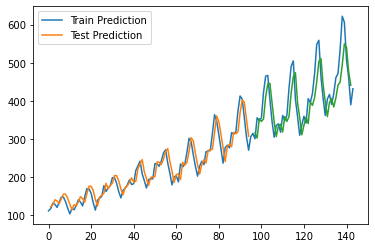

In [65]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['Train Prediction', 'Test Prediction'])
plt.show()